### GAN with the MNIST dataset

In [81]:
from tensorflow.keras.datasets.mnist import load_data

In [82]:
(x_train, x_test), (_,_ ) = load_data()
print('Training data:',x_train.shape, x_test.shape)

Training data: (60000, 28, 28) (60000,)


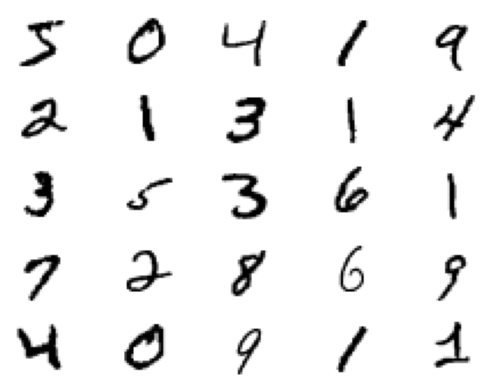

In [83]:
# Visualising the data
import matplotlib.pyplot as plt
for i in range(25):
  plt.subplot(5,5,1 + i)
  plt.axis('off')
  plt.imshow(x_train[i], cmap = 'gray_r')
plt.show()

In [84]:
# Importing dependencies
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [85]:
x_train = x_train.reshape(x_train.shape[0], 28,28, 1).astype('float32') # Resshaping to 28,28,1
x_train = (x_train - 127.5) / 127.5 # Noramlizing the input to fall between -1 and 1

In [86]:
buffer_size = 60000 #Number of images load
batch_size = 256

In [87]:
# Shuffling the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [88]:
# Generator function
def build_generator():
  model = tf.keras.Sequential()
  # Low resolution of 7,7 given to the generator
  # The noise vector is 100
  model.add(Dense(7*7*256, use_bias = False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add( layers.LeakyReLU())

  # Pass the new shape as a single tuple
  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7,7,256)

  # Upsampling the image to increase the resolution
  model.add(layers.Conv2DTranspose(128,(5,5), strides= (1,1), padding ='same' , use_bias = False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add( layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5), strides= (2,2), padding ='same',use_bias = False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Final resolution of fake image 28*28 which matches the size of train data
  model.add(layers.Conv2DTranspose(1,(5,5), strides= (2,2), padding ='same',use_bias = False))
  assert model.output_shape == (None,28,28,1)

  return model

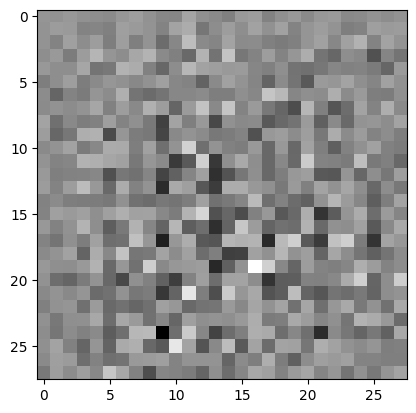

In [89]:
# Generating an image before training
generator = build_generator()
noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

In [90]:
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation= 'sigmoid'))

  return model

In [91]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5000085]], shape=(1, 1), dtype=float32)


In [92]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [93]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [94]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [95]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [96]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [101]:
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)
    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [109]:
!pip install ipython
import IPython.display as display

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)



    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  display.clear_output(wait = True)
  generate_and_save_images(generator, epochs, seed)

In [110]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

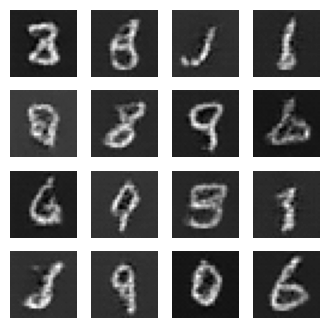

In [111]:
train(train_dataset, EPOCHS)